# Correlation analysis

In [1]:
# Importing necessary libraries
import pandas as pd
import nibabel as nib
import numpy as np
import os
from scipy.stats import pearsonr, spearmanr, normaltest
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.lines import Line2D  # For custom legend handles
import seaborn as sns


## Necessary functions

Functions were defined for data processing, vizualisation and analysis. 

In [2]:
def filter_data(df, columns):
 
    """
    Filters a DataFrame to include only the specified columns and removes rows that do not correspond to predefined MRI scan timepoints

    Args:
        df (pd.DataFrame): The input dataset
        columns (list): List of column names to retain

    Returns:
        pd.DataFrame: The filtered dataset
    """

    # Create a dataset of only the relevant columns
    filtered_df = df[columns].copy()

    # The event names corresponding to the timepoints of the MRI scans
    events = ["V1", "V3", "V4", "V6"]
    
    for index, row in filtered_df.iterrows():

        # Remove rows from events where no MRI scan was conducted
        if row['Event name'] not in events:
            filtered_df = filtered_df.drop(index)

    # Convert patient ID to integers
    filtered_df.loc[:, "Subject sequence number"] = filtered_df.loc[:, "Subject sequence number"].astype(int)

    return filtered_df

In [3]:
def plot_metrics(merged_df, column_name, metrics_columns, corr="Spearman"):
    
    """
    Generates a grid of scatter plots showing the relationship between a given clinical variable and multiple metric columns,
    with displayed correlation coefficients

    Args:
        merged_df (pd.DataFrame): Merged dataset containing both clinical and metric data
        column_name (str): The clinical score column to correlate with each metric
        metrics_columns (list): List of metric column names to include in the plots
        corr (str, optional): Type of correlation to compute ('Spearman' or 'Pearson'). Defaults to 'Spearman'

    Returns:
        None: Displays a matplotlib figure
    """

    # Create a 3x6 grid of subplots
    fig, axes = plt.subplots(3, 6, figsize=(20, 9))  

    # Define colors for different event timepoints
    colors = {"V1": "darkblue", "V3": "green", "V4": "orange", "V6": "magenta"}

    # Flatten the axes array for easy indexing
    axes = axes.flatten() 

    for i, metric in enumerate(metrics_columns):
        x = merged_df[column_name].astype(float)
        y = merged_df[metric].astype(float)

        # Plot scatterplot
        axes[i].scatter(x, y, marker=".", c=merged_df["Event name"].map(colors))

        # Compute correlation and display in plot title
        if corr == "Pearson":
            r, p = pearsonr(x, y)
        else:
            r, p = spearmanr(x, y)

        axes[i].set_title(f"r = {round(r, 3)}, p = {round(p, 3)}")
        axes[i].set_ylabel(metric)

    # Set main title
    if "hand" in column_name or "walk" in column_name:
        fig.suptitle(f"{column_name} [s] - {corr} correlation", fontsize=20, fontweight="bold")
    else:
        fig.suptitle(f"{column_name} - {corr} correlation", fontsize=20, fontweight="bold")

    # Adjust layout
    fig.tight_layout()

    # Add legend for event timepoints
    legend_handles = [
        Line2D([0], [0], marker='o', color='w', markersize=10,
               markerfacecolor=color, label=label)
        for label, color in colors.items()
    ]
    fig.legend(handles=legend_handles, title="Event Name", loc="upper right", bbox_to_anchor=(1.05, 1))

    plt.show()


In [4]:
def remove_outlier(dataset, col_name):
    
    """
    Removes the largest value (outlier) from a specified column in a dataset.

    Args:
        dataset (pd.DataFrame): Input dataset
        col_name (str): The column in which the outlier lies

    Returns:
        pd.DataFrame: A new dataset with the row containing the maximum value removed
    """

    # Find the largest value in the column
    maxvalue = np.max(dataset[col_name].astype(float))

    # Find the index of the largest value
    ind = dataset.index[dataset[col_name].astype(float)==maxvalue]

    # Drop the row(s) with the maximum valu
    dataset = dataset.drop(ind)

    return dataset

In [5]:
def calculate_correlation(merged_df, column_name, metrics_columns, corr="Spearman"):
    """
    Calculates the correlation between a specified column (e.g., a clinical score) 
    and multiple metric columns (e.g., imaging metrics) in a DataFrame

    Args:
        merged_df (pd.DataFrame): The input dataset containing the columns to correlate
        column_name (str): The name of the column to correlate against the metric columns
        metrics_columns (list of str): List of column names to be correlated with "column_name"
        corr (str, optional): Correlation method to use; either "Spearman" (default) or "Pearson"

    Returns:
        list of lists: A list where each element is [r, p], the correlation coefficient and p-value for each metric column in `metrics_columns`.
    """

    # List to store correlation results: [r, p] for each metric
    values_list = []

    for i, metric in enumerate(metrics_columns):
        
        # Extract the variables and ensure they are floats
        x = merged_df[column_name].astype(float)
        y = merged_df[metric].astype(float)

        # Compute correlation using the specified method
        if corr == "Pearson":
            r, p = pearsonr(x, y)
        else:
            r, p = spearmanr(x, y)

        # Round for clarity
        r, p = np.round(r, 3), np.round(p, 3)
        values_list.append([r, p])

    return values_list

## Data Loading and preparation

#### Data loading

The clinical data and global covariance metrics from all subjects were loaded. The covariance metrics were generated using the SPACE-MS algorithm (`run_sspace_ms.py`). The global covariance data from all patients were merged into a single dataset.

In [6]:
# Loading the HADS scores
HADS_df = pd.read_excel('/Data/clinical_data/HADS-data.xlsx', sheet_name="HADS")
HADS_df = HADS_df.rename(columns={'Total score:' : 'HADS score'})

# Loading the T25-FW scores 
FW_df = pd.read_excel('/Data/clinical_data/FW-data.xlsx', sheet_name="FW")

# Loading the 9-HPT scores 
HPT_df = pd.read_excel('/Data/clinical_data/HPT-data.xlsx', sheet_name="HPT")

# Loading the BICAMS test scores 
BS_df = pd.read_excel('/Data/clinical_data/BICAMS-data.xlsx', sheet_name="BS")

In [7]:
# Path to the global lesion metrics
metrics_path = "/SPACE-MS/run_sspace_ms/" 

# Initializing the dataframe global metrics of all patients
metrics_df = pd.DataFrame()
IDs = []
visits = []

# Mapping to ensure correct merging of time points
visits_mapping = {"visit_1":"V1", "visit_2":"V3", "visit_3":"V4", "visit_4":"V6"}

# Looping through al patient files
for patient_visit in sorted(os.listdir(metrics_path)):
    if not patient_visit.startswith("."):

        # Load the CSV containing global lesion metrics
        csv_path = os.path.join(metrics_path, patient_visit, f"{patient_visit}_global_metrics.csv")
        global_metrics = pd.read_csv(csv_path)

        # Extract patient ID and time point
        IDs.append(int(patient_visit[:3])) 
        visits.append(visits_mapping[patient_visit[4:]]) 

        # Concatenating the global metric information of the subjects
        metrics_df = pd.concat([metrics_df, global_metrics])

metrics_columns = metrics_df.columns

# Adding the patient ID and time point to the dataset
metrics_df["Subject sequence number"] = IDs
metrics_df["Event name"] = visits

### CVLT data correction

The CVLT test, part of the BICAMS battery, contained some discrepancies. Each trial in the CVLT should record either 0 or 1 for each recalled element. Values that did not meet this criterion were considered mistyped and corrected to 1. The average score across the trials was also recalculated. 



In [8]:
# Create a copy to not compromise the original data
BS_copy = BS_df.copy()

In [9]:
# Printing all values that are neither 0 nor 1, these are all mistyped scores
for col in BS_copy.columns:
    if "recall" in col:
        BS_copy.loc[1:, col] = BS_copy.loc[1:, col].astype(float)
        for val in BS_copy.loc[1:, col]:
            if val > 1:        
                print(val)

11.0
11.0
11.0
101.0
10.0
11.0
10.0
10.0
11.0
11.0


In [10]:
# Ensure all values are floats
BS_copy.loc[1:, BS_copy.columns.str.contains("Trial")] = BS_copy.loc[1:, BS_copy.columns.str.contains("Trial")].astype(float)

# Change all mistyped values to 1
BS_copy.loc[1:, BS_copy.columns.str.contains("recall")] = BS_copy.loc[1:, BS_copy.columns.str.contains("recall")].where((BS_copy.loc[1:, BS_copy.columns.str.contains("recall")].isna()) | (BS_copy.loc[1:, BS_copy.columns.str.contains("recall")]<= 1), 1)

In [11]:
CVLT_dict = {}

for i in range(1, 6):

    # Compute and save the mean value of the different trials for all subjects
    trial = BS_copy.loc[1:, BS_copy.columns.str.contains(f"Trial {i} recall")] 
    mean_val = round(np.mean(trial, axis=1).astype(float), 1)
    CVLT_dict.setdefault(f"Trial {i} recall", mean_val.astype(float))

# Compute the average score across the five trials
total = round(np.mean(pd.DataFrame(CVLT_dict), axis=1).astype(float), 1)
CVLT_dict.setdefault("CVLT total", total.astype(float))

# Create dataframe of all trials and total score
CVLT_df = pd.DataFrame(CVLT_dict)
CVLT_df = pd.concat((CVLT_df, BS_copy.loc[1:, "Subject sequence number"].astype(float), BS_copy.loc[1:, "Event name"]), axis=1)


### Data merging

The clinical data was merged with the global metric data using the patiend ID and event timepoint. This ensured that corresponding values from both datasets were aligned, simplifying the correlation analysis.

In [12]:
# List of the datasets containing clinical test information
datasets = [FW_df, 
         HPT_df, 
         HPT_df, 
         BS_df, 
         BS_df, 
         HADS_df,
         CVLT_df]

# List of names of the relevant clinical tests
test_names = ['25-foot walk trial 2 time', 
        'Dominant hand trial 2 time', 
        'Non-dominant hand trial 2 time', 
        'BMVT-R, Form 3', 
        'SDMT oral score', 
        'HADS score',
        'CVLT total']

# columns of patient ID and event timepoint
ID_cols = ["Subject sequence number", "Event name"]

In [13]:
# List of all merged datasets, containing clinical information and SPACE-MS metrics
merged_data = []

for data, name in zip(datasets, test_names):

    # Filter the datasets to only contain the clinical information of interest
    filtered = filter_data(data, [name]+ID_cols)

    # Merge the clinical data with the SPACE-MS metric information, and removing all empty rows
    merged = pd.merge(filtered, metrics_df, on=ID_cols, how='inner').dropna()
    merged_data.append(merged)


## Correlation analysis

Correlation coefficients was used to find potential patterns or relationships between the clinical data and the lesion covariance metrics. 

### Checking for Normality

To determine whether Pearson’s or Spearman’s correlation was more appropriate, a statistical test was performed to assess the normality of the clinical test score distributions.

As shown below, none of the clinical test scores followed a normal distribution. Therefore, Spearman’s correlation coefficient was used exclusively in the subsequent analysis.

25-foot walk trial 2 time
statistic: 150.23569273686743, pvalue: 2.3808598414771348e-33  -------  Not Normal!



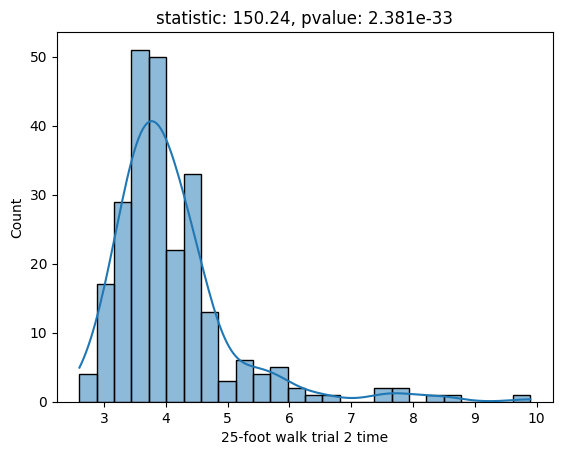


Dominant hand trial 2 time
statistic: 501.03603037865633, pvalue: 1.5900412304917531e-109  -------  Not Normal!



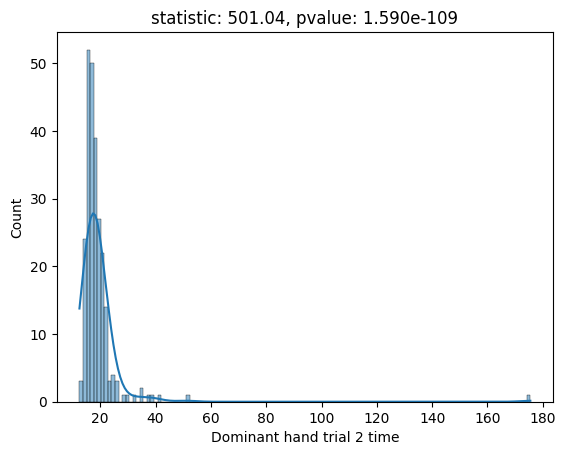


Non-dominant hand trial 2 time
statistic: 210.56853044437048, pvalue: 1.886360017685038e-46  -------  Not Normal!



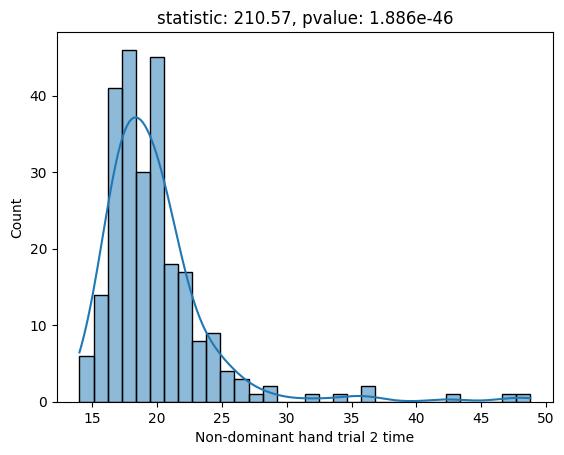


BMVT-R, Form 3
statistic: 79.66710587882444, pvalue: 5.0177354908111505e-18  -------  Not Normal!




SDMT oral score
statistic: 344.05827076080766, pvalue: 1.9439978384896403e-75  -------  Not Normal!




HADS score
statistic: 23.742813328724974, pvalue: 6.987367623908905e-06  -------  Not Normal!




CVLT total
statistic: 7.304523625874598, pvalue: 0.02593240814001233  -------  Not Normal!



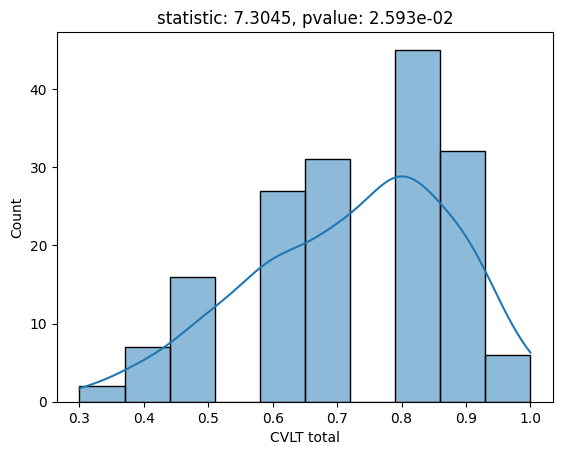

In [14]:
for data, name in zip(merged_data, test_names):

    # Applying statistical test to check whether the data is normally distributed
    test = normaltest(data[name].astype(float))
    normality = "Normal!" if test[1] >= 0.05 else "Not Normal!"
    print(data[name].name)
    print(f"statistic: {test[0]}, pvalue: {test[1]}  -------  {normality}")
    print()
    
    # Plotting a histogram to confirm distribution
    sns.histplot(data[name].astype(float), kde=True)
    plt.title(f"statistic: {test[0]:.5}, pvalue: {test[1]:.3e}")
    plt.show() 

    print()

### Correlation visualization

To visualize the relationship between the clinical outcomes and the SPACE-MS metrics, scatterplots were generated. The calculated correlation coefficient was also displayed above each scatterplot.

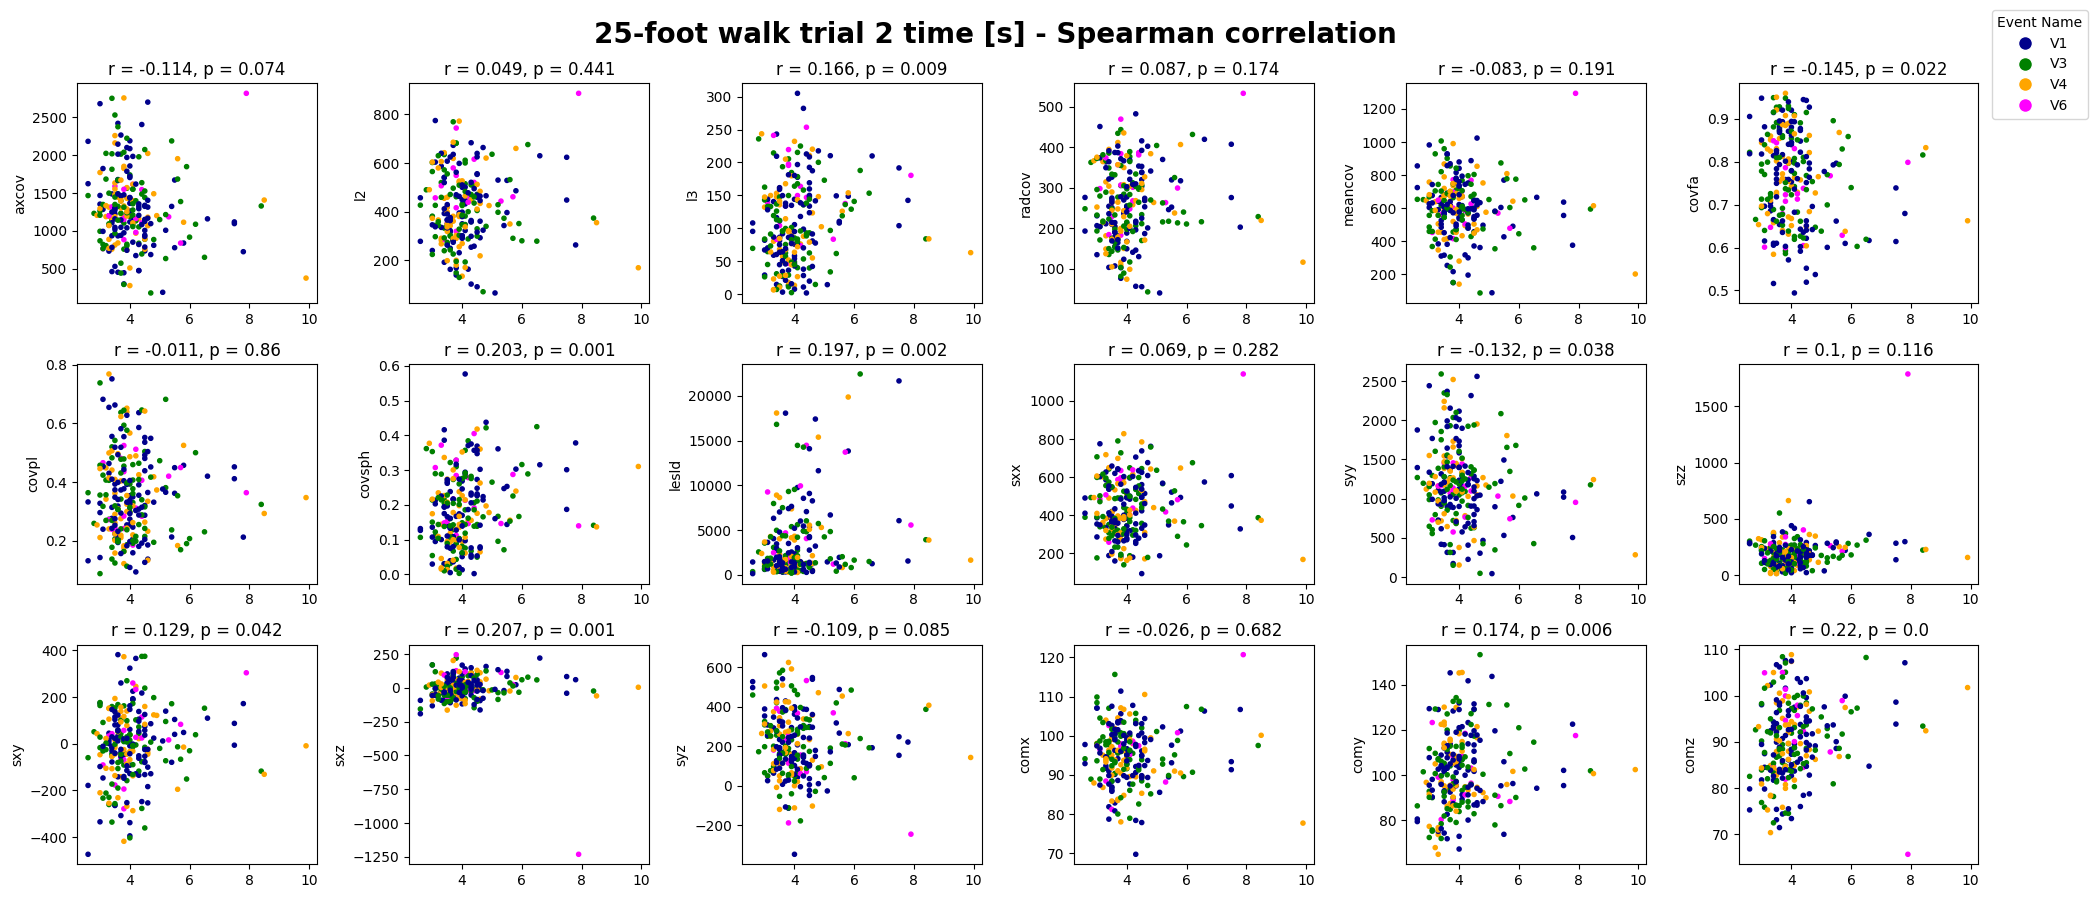

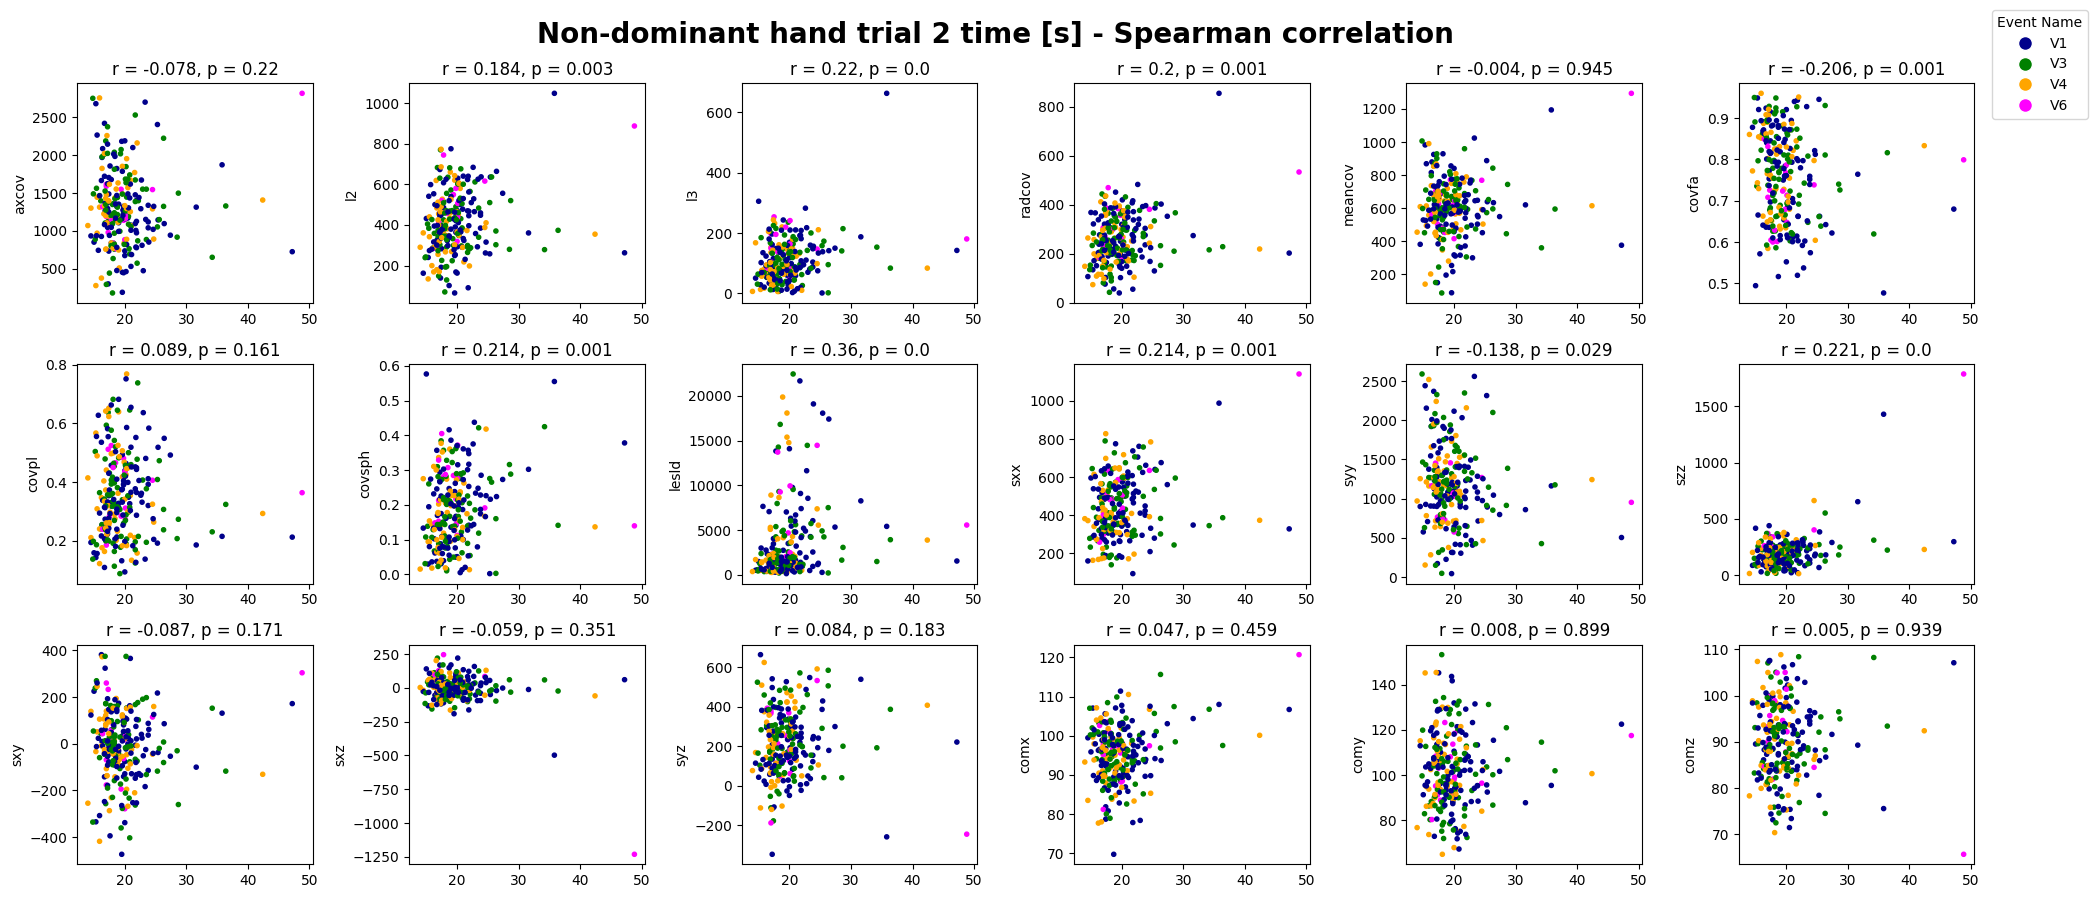

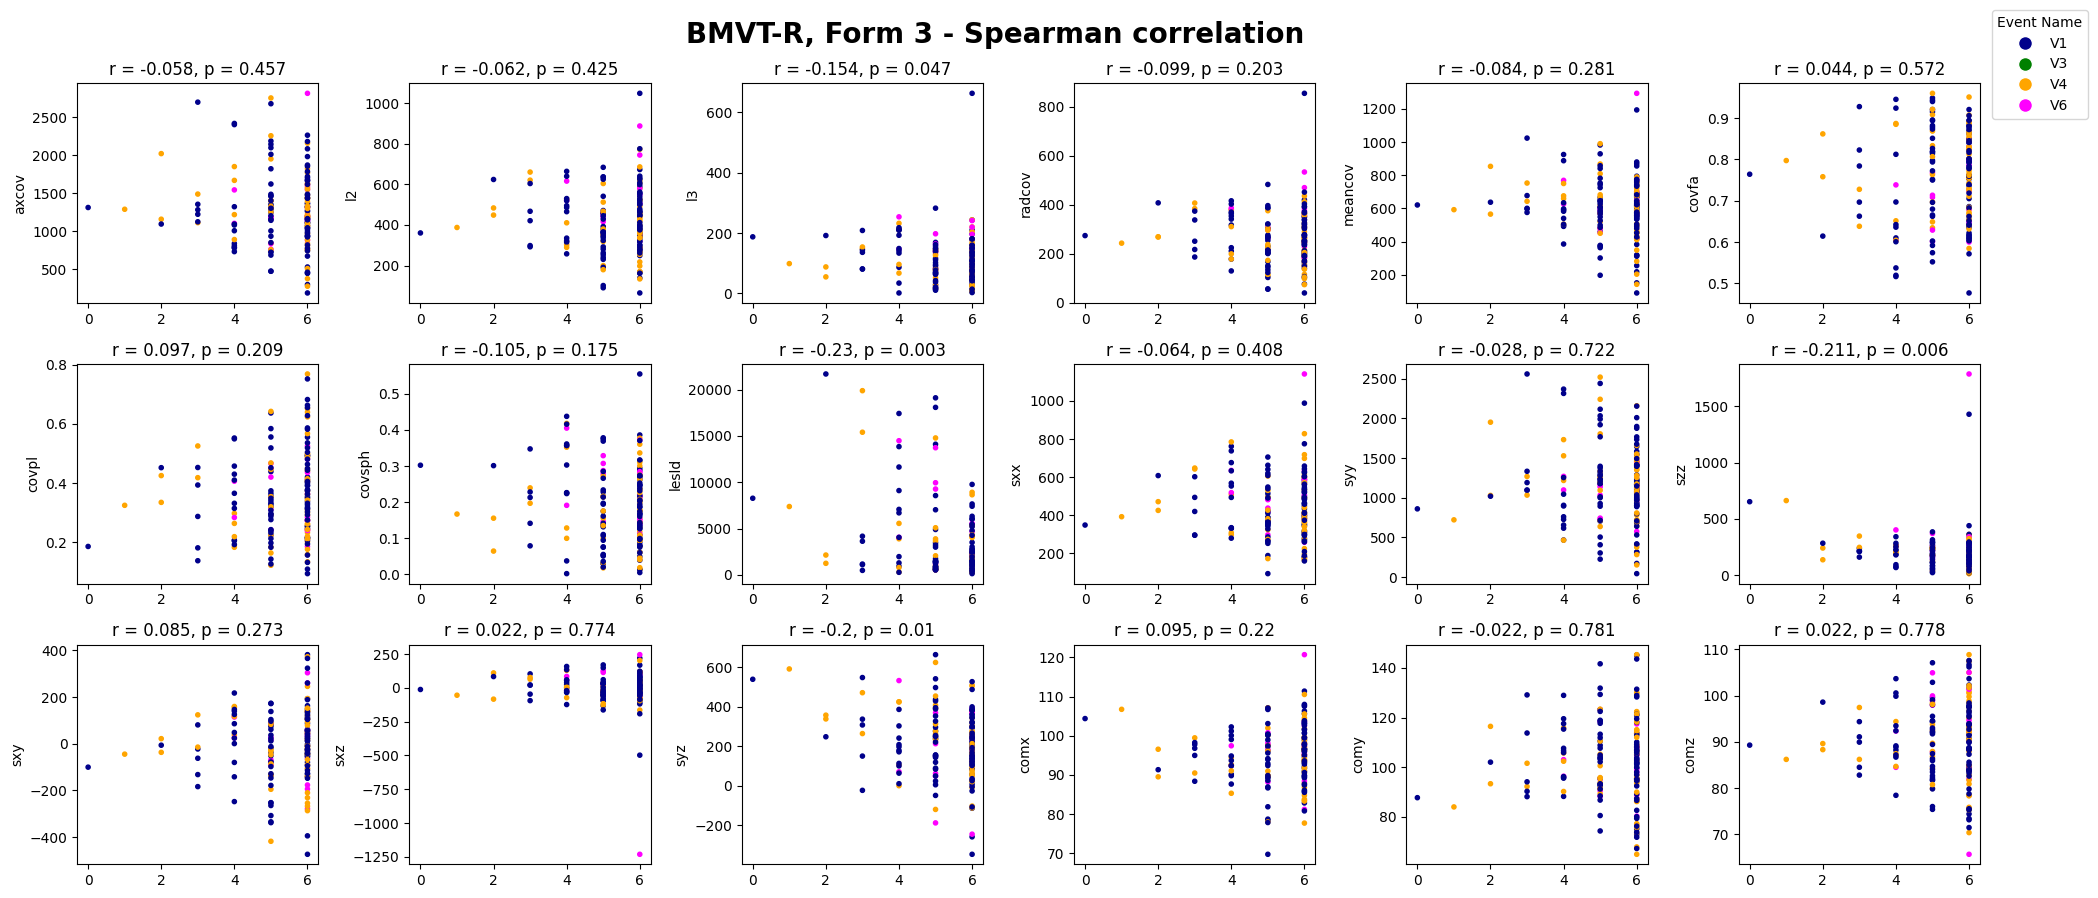

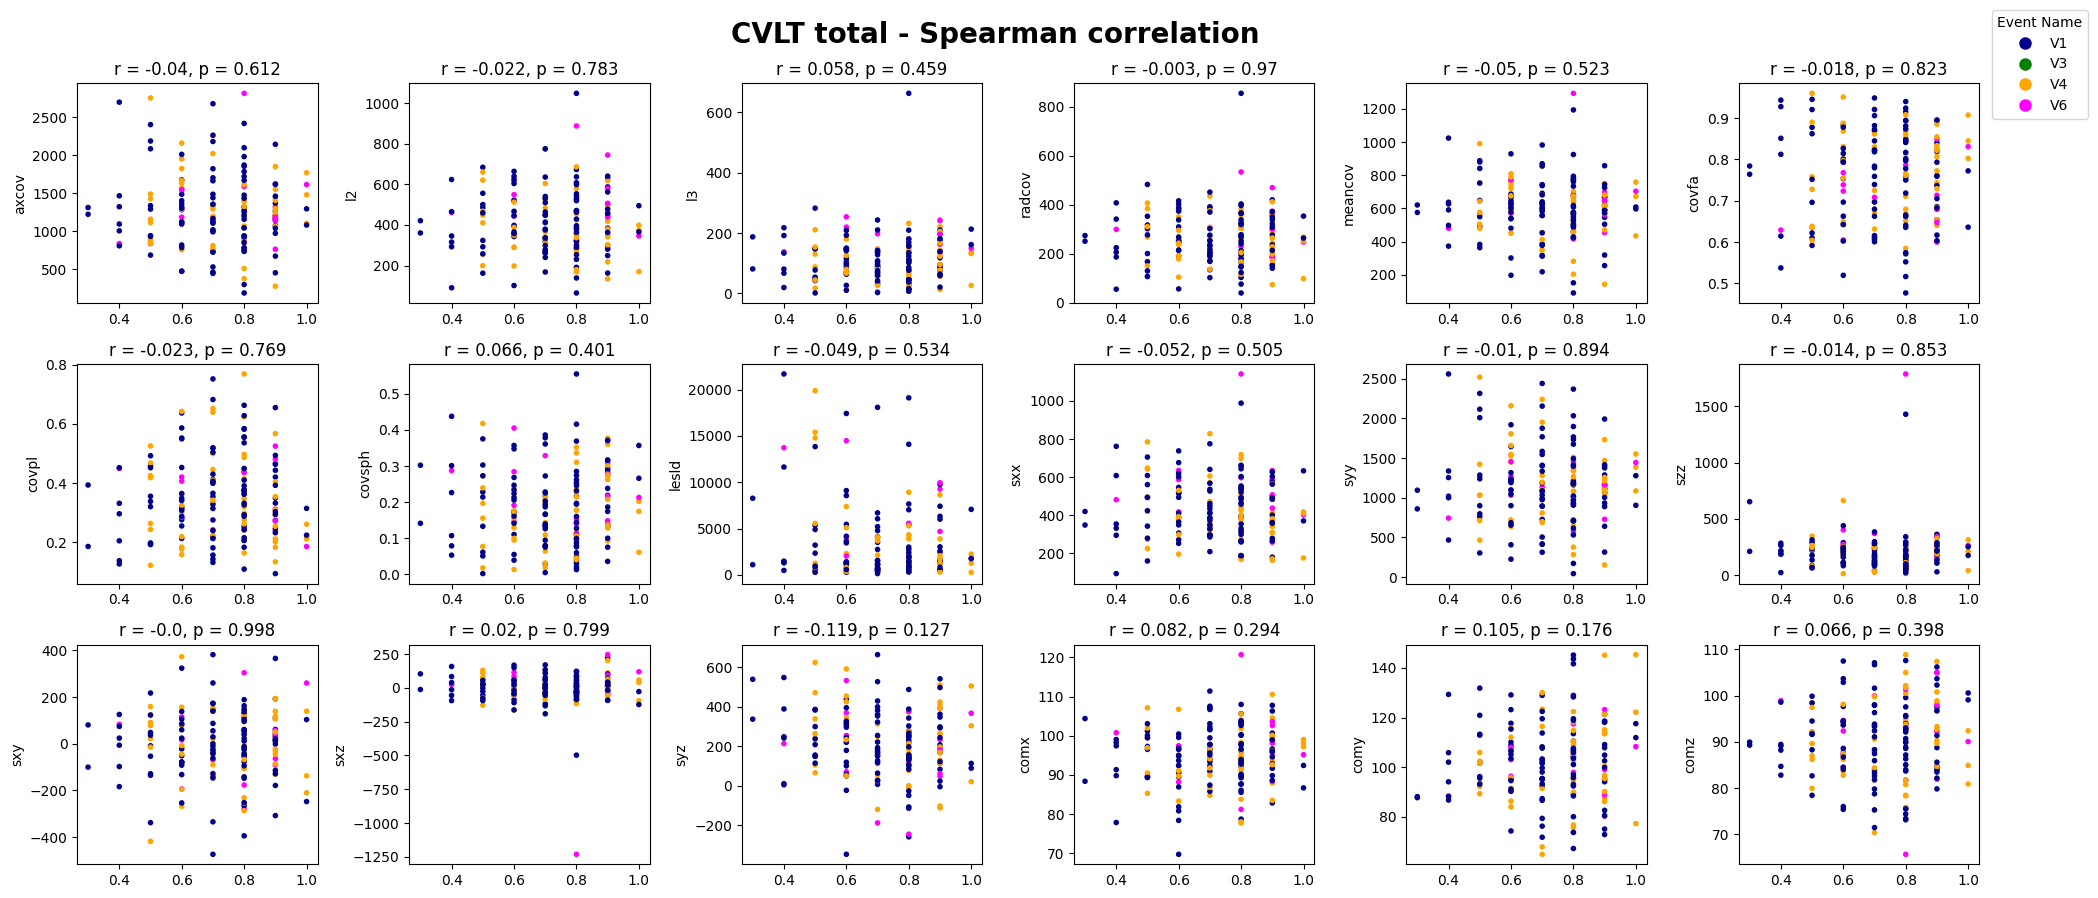

In [15]:
for data, name in zip(merged_data, test_names):

    # Plot grid of scatterplots for each clinical test
    plot_metrics(data, name, metrics_columns, corr='Spearman')

### Identifying outliers

Outliers were identified through visual inspection of the scatterplots. In particular, clear outliers were observed in the 9-HPT (dominant hand) and SDMT plots. To reduce their influence on the correlation analysis, the largest value in each of these datasets was removed

In [16]:
# Removing the outlier from the datasets
merged_data[1] = remove_outlier(merged_data[1], test_names[1])
merged_data[4] = remove_outlier(merged_data[4], test_names[4])

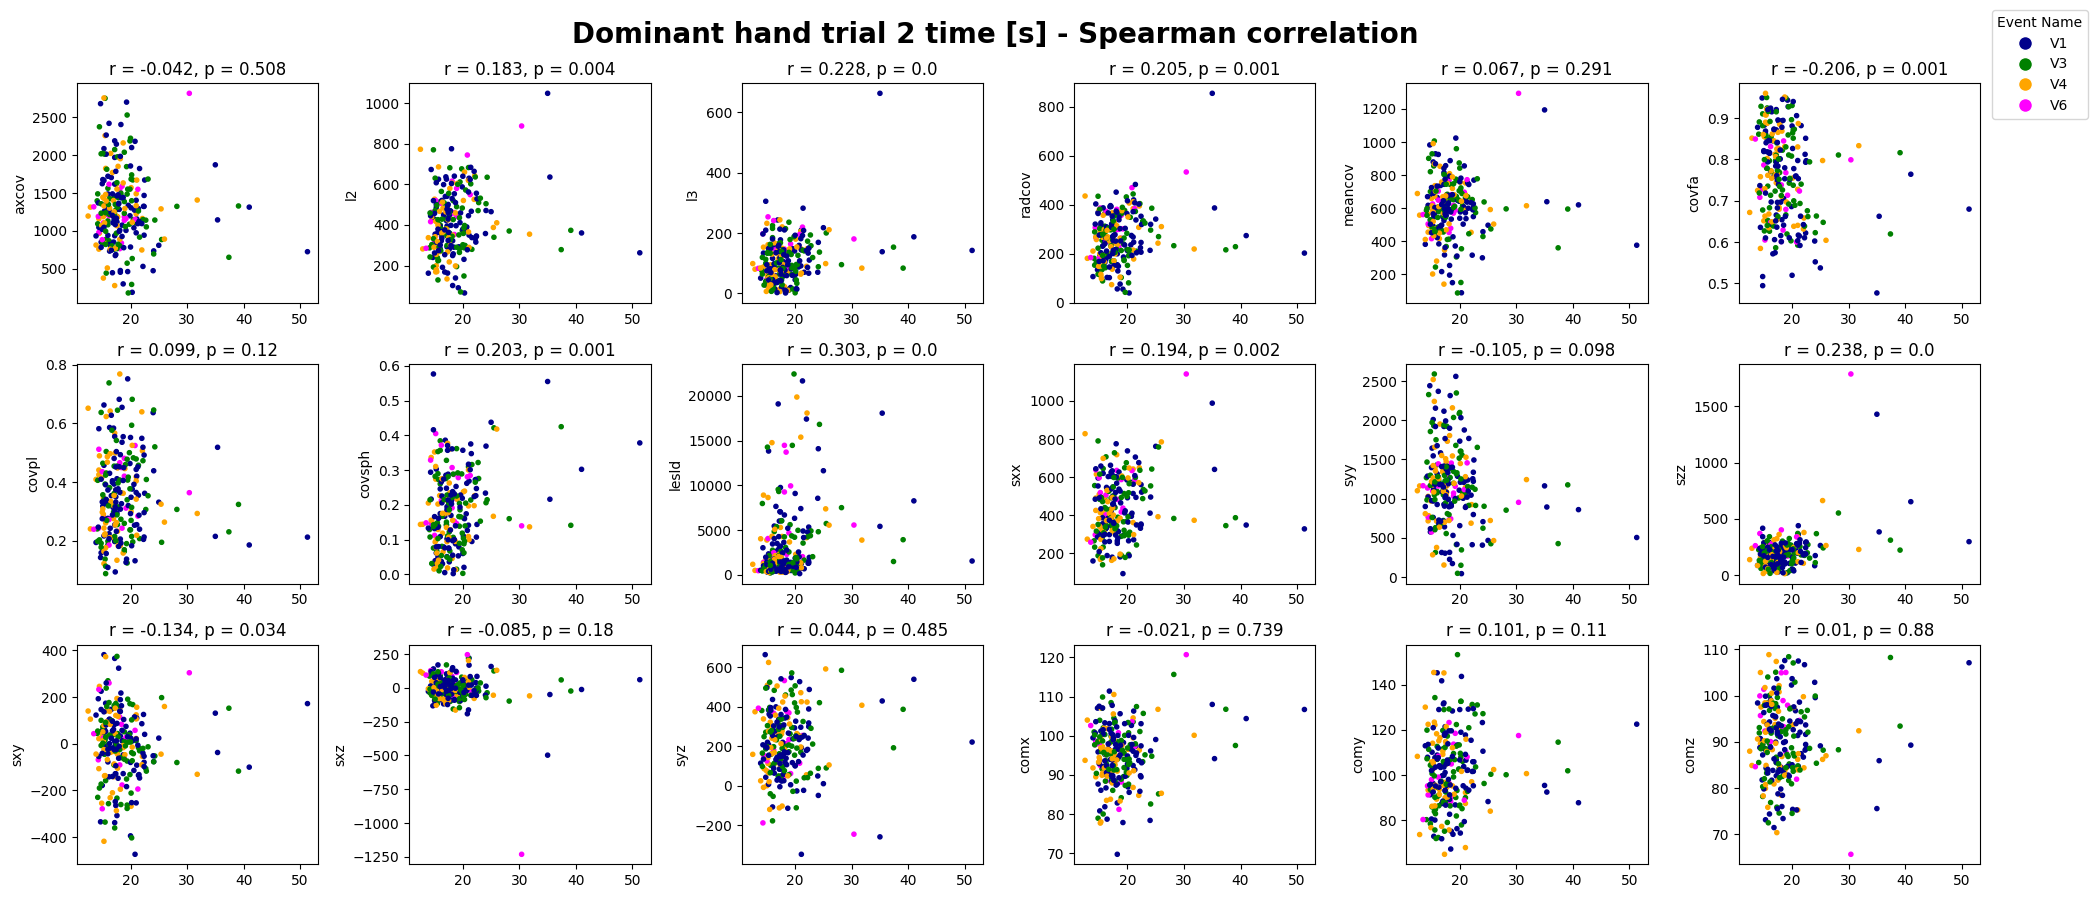

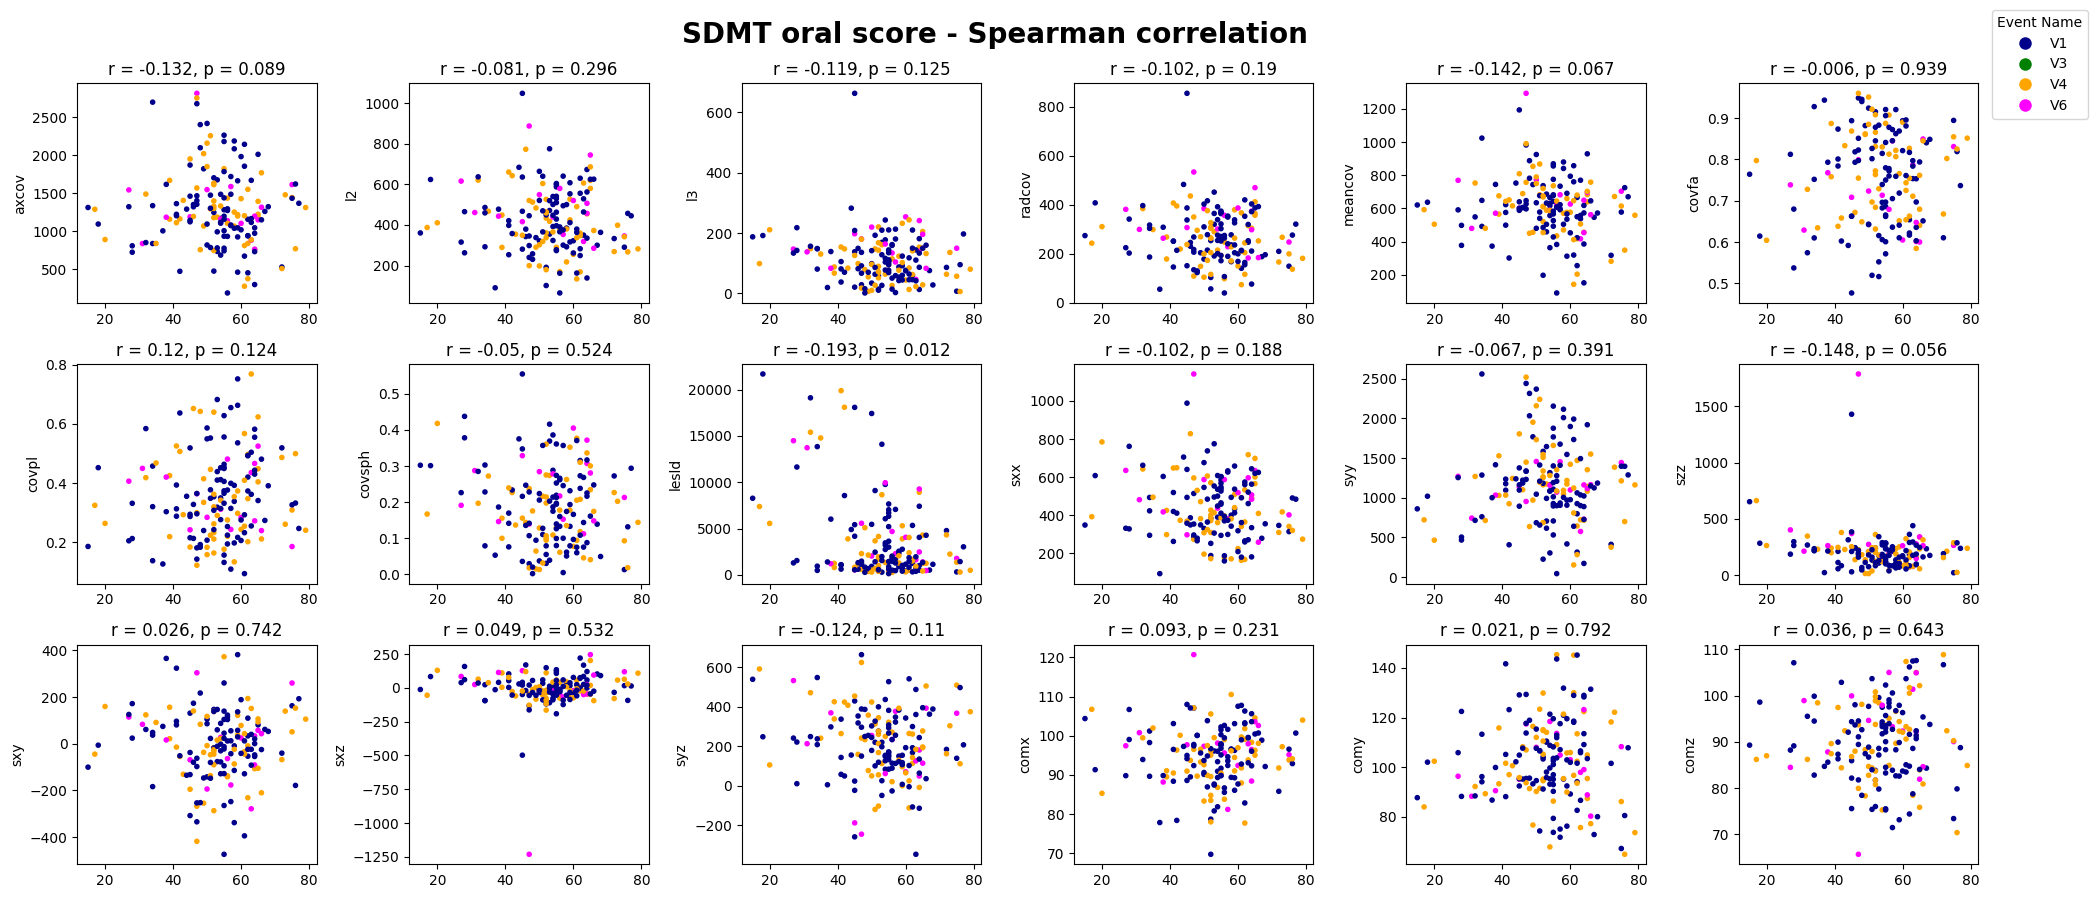

In [17]:
# Plotting the scatterplots again to confirm that the outlier is removed
plot_metrics(merged_data[1], test_names[1], metrics_columns, corr='Spearman')
plot_metrics(merged_data[4], test_names[4], metrics_columns, corr='Spearman')

### Creating correlation dataset

All computed correlation coefficients and their corresponding p-values were combined into a single, comprehensive dataset.

In [18]:
# Initialize dictionary to store correlation results
correlation_values = {}

for data, name in zip(merged_data, test_names):

    # Adding the correlation value and he p-value to the dictionary for all clinical tests
    correlation_values[name] = calculate_correlation(data, name, metrics_columns)

# Converting the dictionary to a DataFrame
corr_df = pd.DataFrame(correlation_values, index=metrics_columns)


In [19]:
split_columns = []

# Restructuring the correlation DataFrame for clarity, by dividing all clinical test columns into two: one for correlation values and one for p-values
for col in corr_df.columns:
    temp_df = corr_df[col].apply(pd.Series)
    temp_df.columns = pd.MultiIndex.from_product([[col], ['r', 'p']])
    split_columns.append(temp_df)

correlation_df = pd.concat(split_columns, axis=1)
correlation_df

25-foot walk trial 2 time        Dominant hand trial 2 time         \
                                r      p                          r      p   
axcov                      -0.114  0.074                     -0.042  0.508   
l2                          0.049  0.441                      0.183  0.004   
l3                          0.166  0.009                      0.228  0.000   
radcov                      0.087  0.174                      0.205  0.001   
meancov                    -0.083  0.191                      0.067  0.291   
covfa                      -0.145  0.022                     -0.206  0.001   
covpl                      -0.011  0.860                      0.099  0.120   
covsph                      0.203  0.001                      0.203  0.001   
lesld                       0.197  0.002                      0.303  0.000   
sxx                         0.069  0.282                      0.194  0.002   
syy                        -0.132  0.038                     -0.105  0.098   
szz                         0.100  0.116                      0.238  0.000   
sxy                         0.129  0.042                     -0.134  0.034   
sxz                         0.207  0.001                     -0.085  0.180   
syz                        -0.109  0.085                      0.044  0.485   
comx                       -0.026  0.682                     -0.021  0.739   
comy                        0.174  0.006                      0.101  0.110   
comz                        0.220  0.000                      0.010  0.880   

        Non-dominant hand trial 2 time        BMVT-R, Form 3         \
                                     r      p              r      p   
axcov                           -0.078  0.220         -0.058  0.457   
l2                               0.184  0.003         -0.062  0.425   
l3                               0.220  0.000         -0.154  0.047   
radcov                           0.200  0.001         -0.099  0.203   
meancov                         -0.004  0.945         -0.084  0.281   
covfa                           -0.206  0.001          0.044  0.572   
covpl                            0.089  0.161          0.097  0.209   
covsph                           0.214  0.001         -0.105  0.175   
lesld                            0.360  0.000         -0.230  0.003   
sxx                              0.214  0.001         -0.064  0.408   
syy                             -0.138  0.029         -0.028  0.722   
szz                              0.221  0.000         -0.211  0.006   
sxy                             -0.087  0.171          0.085  0.273   
sxz                             -0.059  0.351          0.022  0.774   
syz                              0.084  0.183         -0.200  0.010   
comx                             0.047  0.459          0.095  0.220   
comy                             0.008  0.899         -0.022  0.781   
comz                             0.005  0.939          0.022  0.778   

        SDMT oral score        HADS score        CVLT total         
                      r      p          r      p          r      p  
axcov            -0.132  0.089      0.061  0.432     -0.040  0.612  
l2               -0.081  0.296     -0.024  0.761     -0.022  0.783  
l3               -0.119  0.125      0.127  0.100      0.058  0.459  
radcov           -0.102  0.190      0.004  0.961     -0.003  0.970  
meancov          -0.142  0.067      0.071  0.362     -0.050  0.523  
covfa            -0.006  0.939     -0.024  0.758     -0.018  0.823  
covpl             0.120  0.124     -0.125  0.107     -0.023  0.769  
covsph           -0.050  0.524      0.134  0.083      0.066  0.401  
lesld            -0.193  0.012      0.066  0.398     -0.049  0.534  
sxx              -0.102  0.188     -0.025  0.746     -0.052  0.505  
syy              -0.067  0.391      0.085  0.272     -0.010  0.894  
szz              -0.148  0.056      0.065  0.405     -0.014  0.853  
sxy               0.026  0.742     -0.018  0.814     -0.000 

### Identifying strongest correlations

Correlations with a coefficient greater than 0.2 and a p-value below 0.05 were considered statistically significant. These relationships were extracted and are displayed below.

In [20]:
# Initialize dictionary to store details of the strongest correlations
highest_dict = {'Correlation' : [], 'P-value': [], 'SPACE-MS metric' : [], 'Clinical test': []} 

# Loop through all elements in the correlation dataset
for col in corr_df:
    for row, _ in corr_df.iterrows():
        r, p = corr_df.loc[row, col]

        # If the value is statistically significant, add the correlation information to the dictionary 
        if p <= 0.05 and abs(r)>0.2:
            highest_dict['Correlation'].append(r)
            highest_dict['P-value'].append(p)
            highest_dict['SPACE-MS metric'].append(row)
            highest_dict['Clinical test'].append(col)

# Convert the dictionary to a DataFrame
highest_corr_df = pd.DataFrame(highest_dict)

# Sort the correlation values in descending order
highest_corr_df = highest_corr_df.sort_values(by=['Correlation'], ascending=False, key=abs)
highest_corr_df

Correlation  P-value SPACE-MS metric                   Clinical test
12        0.360    0.000           lesld  Non-dominant hand trial 2 time
7         0.303    0.000           lesld      Dominant hand trial 2 time
8         0.238    0.000             szz      Dominant hand trial 2 time
15       -0.230    0.003           lesld                  BMVT-R, Form 3
3         0.228    0.000              l3      Dominant hand trial 2 time
14        0.221    0.000             szz  Non-dominant hand trial 2 time
2         0.220    0.000            comz       25-foot walk trial 2 time
9         0.220    0.000              l3  Non-dominant hand trial 2 time
11        0.214    0.001          covsph  Non-dominant hand trial 2 time
13        0.214    0.001             sxx  Non-dominant hand trial 2 time
16       -0.211    0.006             szz                  BMVT-R, Form 3
1         0.207    0.001             sxz       25-foot walk trial 2 time
10       -0.206    0.001           covfa  Non-dominant hand trial 2 time
5        -0.206    0.001           covfa      Dominant hand trial 2 time
4         0.205    0.001          radcov      Dominant hand trial 2 time
6         0.203    0.001          covsph      Dominant hand trial 2 time
0         0.203    0.001          covsph       25-foot walk trial 2 time